In [1]:
import bz2
import os
import pickle
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
DATA_PATH = './data'
september_dataset = os.path.join(DATA_PATH, '09_prepared.pkl.bz2')
october_dataset = os.path.join(DATA_PATH, '10_prepared.pkl.bz2')
november_dataset = os.path.join(DATA_PATH, '11_prepared.pkl.bz2')

In [3]:
with bz2.open(september_dataset, 'rb') as file:
    df = pickle.load(file)

In [3]:
with bz2.open(october_dataset, 'rb') as file:
    dfo = pickle.load(file)

In [ ]:
with bz2.open(november_dataset, 'rb') as file:
    dfn = pickle.load(file)

### Consider id_cards with both non positive sum or non positive quantity as outliers

In [26]:

res_df = df[(df['sum'] < 0) | (df['quantity'] < 0)]
res_outliers = res_df.id_card_int


In [28]:
print("# of outliers:", len(res_outliers))
outliers_set = set(res_outliers)
print("# of unique outliers:", len(outliers_set))


# of outliers: 137
# of unique outliers: 58


### Find out some unspecific conditions of outliers

Consider the case of sum=0.

In [29]:
res_df = df[df['sum'] == 0.0].sort_values('quantity', ascending=False)
res_df.head()

,date,id_doc,id_order,id_card,id_tov,id_kontr,quantity,sum,is_green,id_card_int,id_doc_int
6039525,2020-09-05 21:13:52,300C5AB6-A3EF-EA11-B444-005056A7539A,0,4744301,1113,-9999,5000.0,0.0,False,870454,4394426
12321204,2020-09-09 16:58:44,C6477CCC-A4F2-EA11-B444-005056A7539A,0,3937328,1113,-9999,5000.0,0.0,False,697590,18136281
16893288,2020-09-13 20:49:52,F7ED67C1-E9F5-EA11-B444-005056A7539A,0,3711713,1113,-9999,5000.0,0.0,False,652196,22680101
34221202,2020-09-25 19:45:53,98C2C76E-50FF-EA11-B444-005056A7539A,0,9359546,1113,-9999,5000.0,0.0,False,1625641,13975815
17568119,2020-09-13 16:13:42,EC0384CD-C3F5-EA11-B444-005056A7539A,0,B014716,1113,-9999,5000.0,0.0,False,1781537,21589222


There are some transactions with `id_kontr` being -9999 (those, None) and having equal `quantity`=5000. Let's consider these transactions and their id_cards as outliers.

In [30]:
print('Number of suspicious transactions:', 
      len(df[(df['sum'] == 0.0)&(df['quantity'] == 5000)]))
print('Number of suspicious cards:', 
      len(df[(df['sum'] == 0.0)&(df['quantity'] == 5000)].id_card_int.unique()))

Number of suspicious transactions: 1092
Number of suspicious cards: 715


In [31]:
res_outliers = set(df[(df['sum'] == 0.0)&(df['quantity'] == 5000)].id_card_int.unique())
outliers_set = outliers_set.union(res_outliers)

### Find out some unspecific conditions of outliers #2

Let's find out the richest people in our dataset and filter them out.

In [46]:
res_df = df.groupby('id_card_int', as_index=False)['sum'].sum().sort_values('sum', ascending=False)
res_df.head()

,id_card_int,sum
652503,883386,18259091.85
426570,568930,211154.31
910003,1243870,124131.91
1260542,1755035,116411.20
1054559,1447941,98215.49


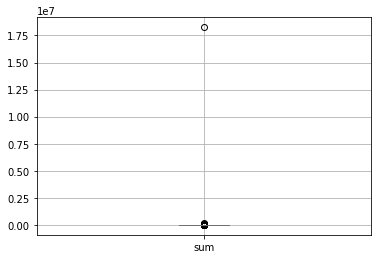

In [49]:
res_df[['sum']].boxplot();

# Logarthmic plot

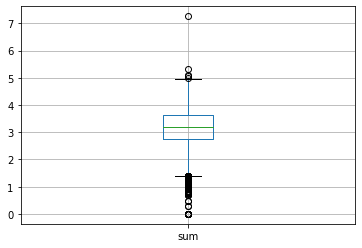

In [53]:
import numpy as np
res_df_ = res_df[res_df['sum'] == 0]
z = pd.Series(np.log10(res_df['sum']+1))
pd.DataFrame(z).boxplot();

lets use then threshold of 10^5  = ~100000

But there are also situations when a customer has total `sum` equal 0. This is also strange situation and they may be considered as outliers.

In [62]:
res_df.sort_values('sum').tail(500)

,id_card_int,sum
948089,1297710,50942.99
1228873,1705441,50952.78
109197,142812,50954.87
177538,232098,50964.42
340300,450863,50966.50
...,...,...
1054559,1447941,98215.49
1260542,1755035,116411.20
910003,1243870,124131.91
426570,568930,211154.31


Finally, let's find out the outliers. Let's not remove much rich people (just the most obvious samples).

In [65]:
res_outliers = set(res_df[(res_df['sum'] > 100000)]['id_card_int'].unique())
outliers_set = outliers_set.union(res_outliers)

In [66]:
print(res_outliers)

{883386, 1755035, 1243870, 568930}


### Filter out id_cards having orders with abnormal sum

In [67]:
res_df = df.groupby(['id_doc', 'id_card_int'], as_index=False)['sum'].sum()
res_df.head()

,id_doc,id_card_int,sum
0,00000230-16FC-EA11-B444-005056A7539A,1425208,396.00
1,00000292-91FE-EA11-B444-005056A7539A,1438933,1597.00
2,00000450-F1FC-EA11-B444-005056A7539A,293299,254.00
3,00000A30-E700-EB11-B444-005056A7539A,883386,180.00
4,00000C88-A3F6-EA11-B444-005056A7539A,715970,709.06


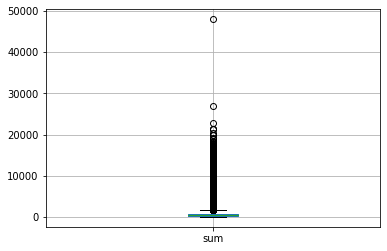

In [68]:
res_df[['sum']].boxplot();

Let's define the threshold to be 22000.

In [70]:
res_outliers = set(res_df[res_df['sum'] > 22000]['id_card_int'].unique())
outliers_set = outliers_set.union(res_outliers)

### Too frequent purchases

In [71]:
df['day'] = df['date'].dt.date

Let's consider that customers usually don't go to the shop too often - (for this experiment) no more than once per day.

In [72]:
res_df = df.groupby('id_card_int', as_index=False)['day'].nunique().sort_values('day', ascending=False)
res_df.head()

,id_card_int,day
209008,273464,30
30845,39724,30
1303506,1822553,30
1278881,1784079,30
365911,485450,30


1

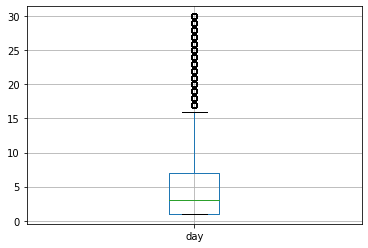

In [73]:
res_df[['day']].boxplot();

In [75]:
res_outliers = set(res_df[(res_df['day'] > 31) & (res_df['day'] < 1)]['id_card_int'].unique())
outliers_set = outliers_set.union(res_outliers)

### Finalize and save results

In [76]:
print('Total number of outliers:', len(outliers_set))

Total number of outliers: 777


In [79]:
res_df = pd.DataFrame(outliers_set, columns=['ZBR'])

In [80]:
RESULT_PATH = './zbr.pkl.bz2'

with bz2.open(RESULT_PATH, 'wb') as file:
    pickle.dump(res_df, file, protocol=4)

In [81]:
res_df.head()

,ZBR
0,1679367
1,1310735
2,1003537
3,165905
4,126995
